# Environment Setup
Install all the necessary packages required for running the article retrieval system.

In [2]:
!pip install chromadb pandas numpy langchain openai matplotlib python-dotenv tiktoken lark langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Packages descriptions
- **chromadb** - for vector storage, integrates with LangChain for advanced data retrieval.
- **pandas** - data manipulation and analysis with powerful data structures.
- **numpy** - supports scientific computing with extensive array and matrix functionalities.
- **langchain** - facilitates the development of language applications with built-in text processing tools.
- **langchain_openai** - enhances LangChain integration with OpenAI services, facilitating the use of OpenAI embeddings and APIs.
- **openai** - official OpenAI library for accessing AI models and APIs.
- **matplotlib** - creates visualizations for data analysis and display.
- **python-dotenv** - manages environment variables from `.env` files.
- **tiktoken** - handles tokenization for text processing tasks.
- **lark** - modern parser for constructing syntax trees from textual data.


I am using google colaboratory and upload this dataset in this way manually.

In [13]:
# from google.colab import files
# uploaded = files.upload()

Saving medium.csv to medium.csv


You can go to https://www.kaggle.com/datasets/meruvulikith/1300-towards-datascience-medium-articles-dataset page where you can download such dataset.

In [14]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import TokenTextSplitter
from langchain.vectorstores import Chroma
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains import RetrievalQA
from langchain.chains.query_constructor.base import AttributeInfo
from langchain_core.prompts import PromptTemplate
from langchain_openai import OpenAI, OpenAIEmbeddings

### API Key Configuration
Setting up the OpenAI API key for accessing embedding services. While this notebook hardcodes the API key for simplicity, it's recommended to use environment variables for security and create `.env` file and store OPENAI_API_KEY variable with your key associated with it.


In [15]:
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

openai.api_key = OPENAI_API_KEY

# Data Loading and Preparation
Load the dataset into a pandas DataFrame for preprocessing and analysis. Utilize the DataFrameLoader from LangChain for efficient loading and explore the first few rows to understand the dataset structure.


In [16]:
df = pd.read_csv("./medium.csv")

### Dataset Overview
Generate a summary of the dataset using `info()` and `describe()` methods from pandas. This provides insights into the data types, count of non-null values, and statistical overview of numeric columns.

In [17]:
df.head()

,Title,Text
0,A Beginner’s Guide to Word Embedding with Gens...,1. Introduction of Word2vec\n\nWord2vec is one...
1,Hands-on Graph Neural Networks with PyTorch & ...,"In my last article, I introduced the concept o..."
2,How to Use ggplot2 in Python,Introduction\n\nThanks to its strict implement...
3,Databricks: How to Save Data Frames as CSV Fil...,Photo credit to Mika Baumeister from Unsplash\...
4,A Step-by-Step Implementation of Gradient Desc...,A Step-by-Step Implementation of Gradient Desc...


Also it is worth to know some information about current dataset, so that we are using .info() and .describe() methods provided by pandas.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1391 entries, 0 to 1390
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   1391 non-null   object
 1   Text    1391 non-null   object
dtypes: object(2)
memory usage: 21.9+ KB


Load data using DataFrameLoader provided by LangChain

In [19]:
loader = DataFrameLoader(df, page_content_column="Text")
docs = loader.load()

Display the loaded documents to verify the loading process. Each document consists of `page_content` with the article text and `metadata` including the article title.

In [20]:
print("Number of docs loaded: ", len(docs))
print("First three docs\n", docs[:3])

Number of docs loaded:  1391
First three docs
 [Document(page_content='1. Introduction of Word2vec\n\nWord2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men, and human might cluster in one corner, while yellow, red and blue cluster together in another.\n\nThere are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can

# Document Splitting
Divide the dataset into manageable chunks using the TokenTextSplitter from LangChain. We are prioritizng words (tokens), instead of characters, since words carry more meaningful linguistic information comparing to characters.

But which chunk size could be optimal? Let's explore our article data more deeply.

Analyze the distribution of word counts in articles to determine the approximate chunk size for processing. Calculate the mean and median.

In [21]:
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))

mean_word_count = df['word_count'].mean()
median_word_count = df['word_count'].median()
print('mean word count', mean_word_count)
print('median word count', median_word_count)

mean word count 901.5384615384615
median word count 516.0


Utilize matplotlib to plot the distribution of word counts. Visualization helps to better understand the data and helps to come up with chunking strategy.

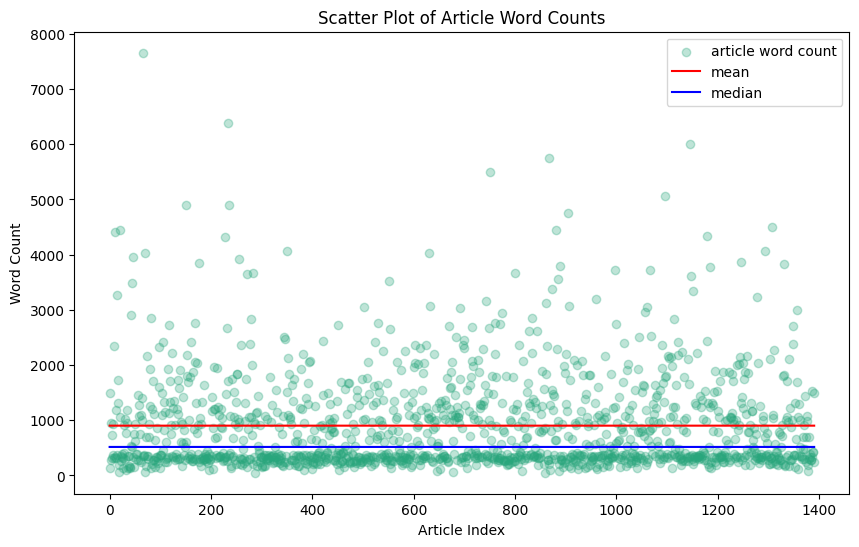

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['word_count'], alpha=0.3, color='#28a67c', label="article word count")
plt.plot(df.index, np.ones(len(docs)) * mean_word_count, color="red", label="mean")
plt.plot(df.index, np.ones(len(docs)) * median_word_count, color="blue", label="median")
plt.title('Scatter Plot of Article Word Counts')
plt.xlabel('Article Index')
plt.ylabel('Word Count')
plt.legend()
plt.show()

In [23]:
chunk_size = int(mean_word_count / 4)
overlap_percent = 0.1
chunk_overlap = int(chunk_size * overlap_percent)

text_splitter = TokenTextSplitter(
	chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

print('chunk size', chunk_size, '\nchunk overlap', chunk_overlap)

docs_splitted = text_splitter.split_documents(docs)
print('docs length', len(docs),'\nsplitted docs length', len(docs_splitted))

chunk size 225 
chunk overlap 22
docs length 1391 
splitted docs length 9490


In [24]:
docs_splitted[:2]

[Document(page_content='1. Introduction of Word2vec\n\nWord2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men, and human might cluster in one corner, while yellow, red and blue cluster together in another.\n\nThere are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW m

# Data Embedding and Storing
Set up the embedding process using OpenAI's API. This step involves configuring the embedding parameters and ensuring the API key is correctly set up for accessing the service.

In [25]:
embedding = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

Generate embeddings for a sample text to demonstrate the process and inspect the output. This helps verify that the embeddings are being created correctly and are suitable for use in vector-based retrieval.

In [26]:
vector = embedding.embed_query("What a fantastic project!")
np.array(vector).shape

(1536,)

Remove database files if you have currently

```
!rm -rf ./docs/chroma
```



Initialize the Chroma vector database and configure the directory structure for storing embeddings. This ensures that the storage solution is ready for receiving and indexing the generated embeddings.

In [27]:
vectordb = Chroma.from_documents(
    documents=docs_splitted,
    embedding=embedding,
    persist_directory="docs/chroma/"
)

Execute a sample document retrieval by searching within the embeddings using Euclidean distance. Set 'k' to determine the number of closest vectors returned.

In [29]:
question = "What is euclidean similarity?"
question_vector = embedding.embed_query(question)
searched_docs = vectordb.similarity_search_by_vector(question_vector, k=3)
searched_docs

[Document(page_content='gorithm works?\n\nIn the classification setting, the K-nearest neighbor algorithm essentially boils down to forming a majority vote between the K most similar instances to a given “unseen” observation. Similarity is defined according to a distance metric between two data points. A popular one is the Euclidean distance method\n\nOther methods are Manhattan, Minkowski, and Hamming distance methods. For categorical variables, the hamming distance must be used.\n\nLet’s take a small example. Age vs loan.\n\nWe need to predict Andrew default status (Yes or No).\n\nCalculate Euclidean distance for all the data points.', metadata={'Title': 'A Simple Introduction to K-Nearest Neighbors Algorithm'}),
 Document(page_content=' Cosine similarity of the corresponding CLS sentence-level embeddings.\n\nEuclidean distance\n\nCosine similarity\n\nThe Euclidean distance has a range of [0, ∞), therefore, to match the other scores, let’s use the function f(x)=(1/1.2)^x to get a (0,

Manually calculate similarity scores between searched documents to understand the logic behind distance calculations and relevance scoring in the embedding space.


In [30]:
first_searched_doc_vector = embedding.embed_query(searched_docs[0].page_content)
second_searched_doc_vector = embedding.embed_query(searched_docs[1].page_content)

In [31]:
print('question and first doc score', np.dot(question_vector, first_searched_doc_vector))
print('question and second doc score', np.dot(question_vector, second_searched_doc_vector))

question and first doc score 0.8343977326531844
question and second doc score 0.8188263554970876


# Retrieval
Set up the retrieval system to extract relevant information based on specific queries.

Initialize document metadata and descriptions to provide additional context to the large language model.

In [32]:
metadata_field_info = [
	AttributeInfo(
		name="title",
		description="The title of the article",
		type="string",
	),
	AttributeInfo(
		name="text",
		description="The text of the article",
		type="string"
	)
]

document_content_description = "Articles about Data Science"

Configure and use GPT-3.5 Turbo for processing queries.

In [33]:
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0, openai_api_key=OPENAI_API_KEY)

Set up retriever using SelfQueryRetriever

In [34]:
retriever = SelfQueryRetriever.from_llm(
	llm,
	vectordb,
	document_content_description,
	metadata_field_info,
	verbose=True
)

Create useful function for finding right documents.

In [35]:
def search_docs(query):
  retrieved_docs = retriever.get_relevant_documents(query)

  print("Query: " + query + "\n")
  for i in range(len(retrieved_docs)):
    current_doc = retrieved_docs[i]

    print(f"[Article {i + 1}]")
    print("Title:\n" + current_doc.metadata['Title'] + "\n")
    print("Text:\n" + current_doc.page_content[1:400] + "..." + "\n\n")

In [36]:
search_docs("What is gradient descent?")

Query: What is gradient descent?

[Article 1]
Title:
A deeper look at descent algorithms

Text:
ewton’s method provides a quadratic approximation to a function and optimizes that at every step. The biggest disadvantage is that it involves inverting a matrix for the multi-variable case(which can be expensive when dealing with a vector with a lot of features)

Gradient Descent

Gradient descent is the most common optimization algorithm. It is very quick in that the most expensive thing to do ...


[Article 2]
Title:
A deeper look at descent algorithms

Text:
�³⁰→ℝ. With 10 steps, steepest descent generated f(x) = -62434.18 . Within 1000 steps, gradient descent generated f(x) = -61596.84 . In just 10 steps, steepest descent decrease to an f-value lower than that of gradient descent in a 1000 steps!

Keep in mind that the above works really well only because we are dealing with quadratic functions. In general, it does get difficult to find the value fo...


[Article 3]
Title:
A deeper look

# Answering to queries
Create question answering retrieval to get processed answer from the llm with the context of our data.

In [37]:
chain = RetrievalQA.from_chain_type(llm, retriever=vectordb.as_retriever())

Create practical function for question answering system.

In [38]:
def get_answer(query):
  print("Query:\n" + query + "\n")
  print("Answer:\n" + chain({"query": query})['result'][1:] + "\n")

In [39]:
get_answer("What is gradient descent?")

Query:
What is gradient descent?



/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Answer:
Gradient descent is an optimization algorithm commonly used in machine learning and neural networks. It involves taking small steps in the direction of the steepest descent of a cost function in order to find the minimum value. This process is repeated iteratively until the algorithm converges on the optimal solution.

